# Predictive Maintenance¶

### Group Members: HAN Ruijian, HU Wei, YE Rougang, ZHAO Yuqi 

## Summary

### Methods
1. Similar to the previous work, we explore the data and find no direct relations between certain errors and the equipment failure. In addition, there are considerable missing values of statistics of errors. So we seek to mainly use xgboost (Extreme  Gradient Boosting) to deal with the imbalanced classification problem. We also try with the MLP (Multilayer Perceptron) but just get around 0.54 test AUC.
2. We firstly try and find discarding some samples with many missing values in the training set improves the test accuracy.
3. Then we try to discard some features and merge training data of different observation window sizes. Yet it doesn’t improve so much. And the training data of OW1 actually has the highest accuracy in our experiments. But the training data of longer window sizes doesn’t distract the prediction more. 

4. After using the n-fold cross validation with respect to the whole training set, we use the grouped n-fold cross validation w.r.t machines as there may be difference among various machines. With tuning parameters and grouped n-fold cross validation of training data of OW1, we get 0.5734 test AUC.
5. Finally we try to use the averaging of different fine-tuned xgboost of training data of OW1, OW16, OW2 and get 0.59602 test AUC. Though they are correlated, the averaging can indeed reduce generalization error.

### Further Work
1. Due to the time constraint, we haven’t tried the averaging of fine-tuned xgboost of all of different observation window sizes. We think it’s very likely to improve the score.
2. We think finding the similarity of test machines with some machines in the training set through K-means and then focusing on similar machines may work.
3. Use the PCA, t-SNE or some other methods to reduce the dimension of features is also worth trying.

In [54]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import datetime
import os
import copy
import xgboost as xgb 
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Performing grid search
from sklearn.model_selection import GroupKFold
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4


# read training data, simplify indexes and columns' names
def pure_read(file_path):
    df = pd.read_csv(file_path, header = [0, 1], index_col = [0, 1])
    df = df.reset_index([0, 1])
    row_name = df.iloc[:,0] +'-'+ df.iloc[:,1]
    df.index = row_name
    df.columns = ['_'.join(col) for col in df.columns] 
    df = df.drop(df.columns[[0,1]], axis = 1)
    df = df.rename(columns = {df.columns[-1]: 'label'})
    df = df.dropna(subset=['label'])
    return df

# read test data, simplify indexes and columns' names
def pure_read_test(file_path):
    df = pd.read_csv(file_path, header = [0, 1])
    df = df.drop(df.index[0], axis=0)
    df = df.drop(df.columns[0], axis = 1)
    row_name = df.iloc[:,0] +'-'+ df.iloc[:,1]
    df.index = row_name
    df.columns = ['_'.join(col) for col in df.columns] 
    df = df.drop(df.columns[[0,1]], axis = 1)
    return df

# transform date format to DD/MM/YY
def convert_date(string):
    date = datetime.datetime.strptime(string, '%d/%m/%Y').date()
    return str(date)


target = 'label' # response variable
# fit model
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=10, early_stopping_rounds=50):
    '''
    alg: classifier
    dtrain: training data
    predictors: features
    useTrainCV, cv_folds: cross-validation
    early_stopping_rounds: activates early stopping,
    validation error needs to decrease at least every <early_stopping_rounds> round(s) to continue training
    '''
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=10, show_stdv=True)
        #print(cvresult)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['label'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['label'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['label'], dtrain_predprob))
    
    #feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    xgb.plot_importance(alg, title='Feature Importances', ylabel='Feature Importance Score', max_num_features=10)
# fit model and cross validation by machines
def modelfit_gp(alg, dtrain, predictors, gkf, useTrainCV=True, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], folds=gkf,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=10, show_stdv=True)
        #print(cvresult)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['label'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['label'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['label'], dtrain_predprob))
    
    #feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    xgb.plot_importance(alg, title='Feature Importances', ylabel='Feature Importance Score', max_num_features=10)
    
    
# merge features of training and test data with different OW values
def concatenate_data(train_list,test_list):
    # don't want to change original training data
    train_list = copy.deepcopy(train_list)
    test_list = copy.deepcopy(test_list)
    k = len(train_list)
    if not (k==len(test_list)):
        print('Not match!')
        return None
    # add prefix identifier to each data set so that different data sets with same feature name can be merge
    for i,(train,test) in enumerate(zip(train_list,test_list)):
        columns_name = str(i+1) + '_' + train.columns
        train.columns = columns_name
        test.columns = columns_name[:-1]
    
    train = pd.concat(train_list,axis=1,join='inner')
    test = pd.concat(test_list,axis=1,join='inner')
    
    # delete redundant labels
    col1 = '1_label'
    for i in range(k-1):
        col = str(i+2) + '_' + 'label'
        if not (train[col]==train[col1]).all():
            print('error, labels not match!')
        train = train.drop(col, axis=1)
    
    train = train.rename(columns={'1_label':'label'})
    return train, test

# delele those features (columns) most of which are missing values
# delele those samples (rows) most of which are missing values 
def deleteNA(train, test, col_thres_ratio=0.5, row_thres_ratio=0.5):
    col_thres = int(train.shape[0] * col_thres_ratio)
    train = train.dropna(axis='columns', thresh=col_thres)
    test = test[train.columns.drop('label')]
    train = train.dropna(how='all')
    row_thres = int(train.columns.size * row_thres_ratio)
    train = train.dropna(thresh=row_thres)
    train = train.fillna(0)
    test = test.fillna(0)
    return train, test

# delete features based on comparison between False and True label
# f_null is number of missing labelled False, t_null is number of missing labelled True
# balance is ratio of number of False and True in training set
# for those ratio f_null/t_null deviate from balance much, we keep it, delete the others' features
def deleteNA_adp(train, test, diff = 0.1, row_thres_ratio=0.5):
    train = train.dropna(axis='columns', how='all')
    train = train.dropna(how = 'all')
    balance = train.loc[train['label']==False].shape[0]/train.loc[train['label']==True].shape[0]
    for inx in train.columns.drop('label'):
        f_null = train.loc[train['label']==False][inx].isnull().sum()
        t_null = train.loc[train['label']==True][inx].isnull().sum()
        if t_null!=0: 
            ratio = f_null/t_null
            if abs(ratio-balance) < balance*diff: 
                # delete this column in this situation
                train = train.drop(inx,axis=1)
        else:
            if f_null==0:
                train = train.drop(inx,axis=1)
    test = test[train.columns.drop('label')]
    # Now drop some rows
    row_thres = int(train.columns.size * row_thres_ratio)
    train = train.dropna(thresh=row_thres)
    
    train = train.fillna(0)
    test = test.fillna(0)
    return train, test
    
# tune parameters in XGBClassifier
def param_tune(param, train_data, predictors):
    param_test8 = {'scale_pos_weight':[1,3,5,7,9]}
    gsearch8 = GridSearchCV(estimator = XGBClassifier(**param), 
                            param_grid = param_test8, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
    gsearch8.fit(train_data[predictors], train_data['label'])
    print(gsearch8.best_params_)
    param.update(gsearch8.best_params_)
    
    param_test6 = {'reg_lambda':[1e-1, 1e-3, 1e-5, 0]}
    gsearch6 = GridSearchCV(estimator = XGBClassifier(**param), 
                            param_grid = param_test6, scoring='roc_auc', n_jobs=4, iid=False, cv=10)
    gsearch6.fit(train_data[predictors], train_data['label'])
    print(gsearch6.best_params_)
    param.update(gsearch6.best_params_)
    
    param_test1 = {'max_depth':list(range(3,10,2)),'min_child_weight':list(range(1,6,2))}
    gsearch1 = GridSearchCV(estimator = XGBClassifier(**param), 
                            param_grid = param_test1, scoring='roc_auc',n_jobs=4, iid=False, cv=10)
    gsearch1.fit(train_data[predictors], train_data['label'])
    print(gsearch1.best_params_)
    param.update(gsearch1.best_params_)
    
    param_test3 = {'gamma':[i/10.0 for i in range(0,5)]}
    gsearch3 = GridSearchCV(estimator = XGBClassifier(**param), 
                            param_grid = param_test3, scoring='roc_auc', n_jobs=4, iid=False, cv=10)
    gsearch3.fit(train_data[predictors], train_data['label'])
    print(gsearch3.best_params_)
    param.update(gsearch3.best_params_)
    
    param_test4 = {'subsample':[i/10.0 for i in range(6,10)],'colsample_bytree':[i/10.0 for i in range(6,10)]}
    gsearch4 = GridSearchCV(estimator = XGBClassifier(**param), 
                            param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
    gsearch4.fit(train_data[predictors], train_data['label'])
    print(gsearch4.best_params_)
    param.update(gsearch4.best_params_)
    
    print(param)

# get machine id
def machine_id(df):
    machine = df.index
    machine_name = [x.split('-')[0] for x in machine]
    machine_uni = np.unique(machine_name)
    mapping = {}
    for (i,k) in enumerate(machine_uni):
        mapping[k] = i+1
    df['machine_id'] = [mapping[name] for name in machine_name]
    return df

#  get predicted probability of test set
def get_pred(train_data, test_data, param):
    best_param = param
    predictors = test_data.columns
    print('starting tuning parameters:')
    param_tune(param, train_data, predictors=predictors)
    best_param.update({'n_estimators':5000})
    xgb_classifier = XGBClassifier(**best_param)
    modelfit(xgb_classifier, train_data, predictors)
    pred = xgb_classifier.predict_proba(test_data[predictors])
    return pred

# merge training and test data with different OW values given by choose which is a slice
def get_data(choose, train, test):
    train_cat, test_cat = concatenate_data(train[choose],test[choose])
    return train_cat, test_cat

# do all things in one function
def all_in_one(choose, train_data_list, test_data_list, param, diff, row_thres_ratio):
    """
    choose: slice, determine which OW training sets to be used
    train_data_list: a list containing all training data
    test_data_list: a list containing all test data
    param: initial parameters of XGBClassifier
    diff, row_thres_ratio: parameters used in deleting "useless" features and samples, see deleteNA_adp
    """
    train_dd, test_dd = get_data(choose, train_data_list, test_data_list)
    train_dd, test_dd = deleteNA_adp(train_dd, test_dd, diff = diff, row_thres_ratio=row_thres_ratio)
    print('shape of data is:',train_dd.shape, test_dd.shape)
    print('using files:', train_list[choose], test_list[choose])
    print('setting default parameters to:', param)
    print('Now starting training')
    pred = get_pred(train_dd, test_dd, param)
    test_dd['result'] = pred[:,0]
    return test_dd

# output result to file
def write2file(filename, test_list):
    ## get output file
    answer = pd.read_csv('upload_full2/answer 1D OW 16 PW2.csv', parse_dates=True)
    for index, row in answer.iterrows():
        machine_namedate = row['id'].split('-') # get name and date of machine
        machine_namedate2 = machine_namedate[0]+'-'+convert_date(machine_namedate[1]) # convert to form in test data
        prob = 0.0
        for test in test_list:
            prob += test.loc[machine_namedate2,'result']
        prob /= len(test_list)
        answer.loc[index,'Label'] = 1 - prob
    answer.to_csv(filename, index = False)

In [2]:
## get file names and read data
file_dir = 'upload_full2'
train_dir = os.path.join(file_dir, 'training_data')
train_list = [x for x in os.listdir(train_dir) if x.split('.')[-1] == 'csv']
test_dir = os.path.join(file_dir, 'test_feature')
test_list = [x for x in os.listdir(test_dir) if x.split('.')[-1] == 'csv']
print(train_list, '\n', test_list)
# read all data
train_data_list = []
test_data_list = []
for t in train_list:
    train_data_list.append(pure_read(os.path.join(train_dir, t)))
for t in test_list:
    test_data_list.append(pure_read_test(os.path.join(test_dir, t)))

['Training freq 1D, OW 1, PW 2.csv', 'Training freq 1D, OW 16, PW 2.csv', 'Training freq 1D, OW 2, PW 2.csv', 'Training freq 1D, OW 4, PW 2.csv', 'Training freq 1D, OW 8, PW 2.csv'] 
 ['Verification freq 1D, OW 1, PW 2_feature.csv', 'Verification freq 1D, OW 16, PW 2_feature.csv', 'Verification freq 1D, OW 2, PW 2_feature.csv', 'Verification freq 1D, OW 4, PW 2_feature.csv', 'Verification freq 1D, OW 8, PW 2_feature.csv']


Index(['1_count', '1_vMean', '1_vStd', '136088194_count', '136088194_vMean',
       '136088194_vStd', '136088202_count', '136088202_vMean',
       '136088202_vStd', '136088394_count', '136088394_vMean',
       '136088394_vStd', '136088802_count', '136088802_vMean',
       '136088802_vStd', '136089546_count', '136089546_vMean',
       '136089546_vStd', '136110468_count', '136110468_vMean',
       '136110468_vStd', '136216674_count', '136216674_vMean',
       '136216674_vStd', '136222202_count', '136222202_vMean',
       '136222202_vStd', '136222210_count', '136222210_vMean',
       '136222210_vStd', '136222234_count', '136222234_vMean',
       '136222234_vStd', '136222250_count', '136222250_vMean',
       '136222250_vStd', '136222882_count', '136222882_vMean',
       '136222882_vStd', '136223186_count', '136223186_vMean',
       '136223186_vStd', '136224578_count', '136224578_vMean',
       '136224578_vStd', '136224586_count', '136224586_vMean',
       '136224586_vStd', '136224978_count

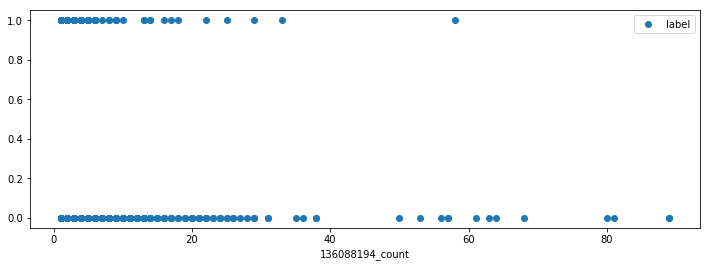

In [21]:
# explorer data
explore_data = train_data_list[0].copy()  # choose the data
explore_data[explore_data.columns[-1]] = explore_data[explore_data.columns[-1]].astype(int)
idx = 3
print(explore_data.columns, explore_data.iloc[:,idx].describe())
print(explore_data.iloc[:,-1].value_counts() )
explore_data.plot(x=explore_data.columns[idx], y=explore_data.columns[-1], ls="none", marker="o")

In [47]:
# check result of data processing
print(train_list[slice(1)])
train_dd, test_dd = get_data(slice(1), train_data_list, test_data_list)
print('shape of data is:',train_dd.shape, test_dd.shape)
train_dd, test_dd = deleteNA_adp(train_dd, test_dd, diff = 0.08, row_thres_ratio=0.75)
print('shape of data is:',train_dd.shape, test_dd.shape)

['Training freq 1D, OW 1, PW 2.csv']
shape of data is: (11707, 82) (3343, 81)
shape of data is: (6623, 17) (3343, 16)


In [25]:
# check result of data processing
print(train_list[slice(1,4)])
train_dd, test_dd = get_data(slice(1,4), train_data_list, test_data_list)
print('shape of data is:',train_dd.shape, test_dd.shape)
train_dd, test_dd = deleteNA_adp(train_dd, test_dd, diff = 0.08, row_thres_ratio=0.75)
print('shape of data is:',train_dd.shape, test_dd.shape)

['Training freq 1D, OW 16, PW 2.csv', 'Training freq 1D, OW 2, PW 2.csv', 'Training freq 1D, OW 4, PW 2.csv']
shape of data is: (11527, 244) (3283, 243)
shape of data is: (5027, 69) (3283, 68)


shape of data is: (6623, 17) (3343, 16)
using files: ['Training freq 1D, OW 1, PW 2.csv'] ['Verification freq 1D, OW 1, PW 2_feature.csv']
setting default parameters to: {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'objective': 'binary:logistic', 'nthread': 4, 'scale_pos_weight': 1, 'random_state': 964, 'missing': 0.0}
Now starting training
starting tuning parameters:
{'reg_lambda': 1e-05}
{'max_depth': 5, 'min_child_weight': 1}
{'gamma': 0.0}
{'colsample_bytree': 0.6, 'subsample': 0.7}
{'scale_pos_weight': 1}
{'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.0, 'subsample': 0.7, 'colsample_bytree': 0.6, 'objective': 'binary:logistic', 'nthread': 4, 'scale_pos_weight': 1, 'random_state': 964, 'missing': 0.0, 'reg_lambda': 1e-05}
[0]	train-auc:0.615038+0.0112404	test-auc:0.548019+0.0325453
[10]	train-auc:0.734667+0.0134997	test-auc:0.579909+0.0316807
[

C:\Users\HU Wei\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


shape of data is: (6623, 17) (3343, 16)
using files: ['Training freq 1D, OW 1, PW 2.csv'] ['Verification freq 1D, OW 1, PW 2_feature.csv']
setting default parameters to: {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'objective': 'binary:logistic', 'nthread': 4, 'scale_pos_weight': 1, 'seed': 287, 'missing': 0.0}
Now starting training
starting tuning parameters:
{'reg_lambda': 0.1}
{'max_depth': 3, 'min_child_weight': 3}
{'gamma': 0.0}
{'colsample_bytree': 0.6, 'subsample': 0.8}
{'scale_pos_weight': 1}
{'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 3, 'min_child_weight': 3, 'gamma': 0.0, 'subsample': 0.8, 'colsample_bytree': 0.6, 'objective': 'binary:logistic', 'nthread': 4, 'scale_pos_weight': 1, 'seed': 287, 'missing': 0.0, 'reg_lambda': 0.1}
[0]	train-auc:0.588194+0.0116156	test-auc:0.543773+0.0336448
[10]	train-auc:0.651258+0.00945396	test-auc:0.578381+0.0428542
[20]	train-auc:0.678

C:\Users\HU Wei\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9074
AUC Score (Train): 0.737732
shape of data is: (6623, 17) (3343, 16)
using files: ['Training freq 1D, OW 1, PW 2.csv'] ['Verification freq 1D, OW 1, PW 2_feature.csv']
setting default parameters to: {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'objective': 'binary:logistic', 'nthread': 4, 'scale_pos_weight': 1, 'seed': 584, 'missing': 0.0}
Now starting training
starting tuning parameters:
{'reg_lambda': 0}
{'max_depth': 9, 'min_child_weight': 5}
{'gamma': 0.0}
{'colsample_bytree': 0.8, 'subsample': 0.8}
{'scale_pos_weight': 1}
{'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 9, 'min_child_weight': 5, 'gamma': 0.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'objective': 'binary:logistic', 'nthread': 4, 'scale_pos_weight': 1, 'seed': 584, 'missing': 0.0, 'reg_lambda': 0}
[0]	train-auc:0.717609+0.0167468	test-auc:0.524755+0.0369798
[10]	train-auc:0.875754+0.0

C:\Users\HU Wei\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9091
AUC Score (Train): 0.938574
shape of data is: (6623, 17) (3343, 16)
using files: ['Training freq 1D, OW 1, PW 2.csv'] ['Verification freq 1D, OW 1, PW 2_feature.csv']
setting default parameters to: {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'objective': 'binary:logistic', 'nthread': 4, 'scale_pos_weight': 1, 'seed': 419, 'missing': 0.0}
Now starting training
starting tuning parameters:
{'reg_lambda': 0.1}
{'max_depth': 3, 'min_child_weight': 1}
{'gamma': 0.0}
{'colsample_bytree': 0.8, 'subsample': 0.6}
{'scale_pos_weight': 1}
{'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.0, 'subsample': 0.6, 'colsample_bytree': 0.8, 'objective': 'binary:logistic', 'nthread': 4, 'scale_pos_weight': 1, 'seed': 419, 'missing': 0.0, 'reg_lambda': 0.1}
[0]	train-auc:0.559469+0.0105533	test-auc:0.53002+0.0355131
[10]	train-auc:0.646861+

C:\Users\HU Wei\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9076
AUC Score (Train): 0.731407
shape of data is: (6623, 17) (3343, 16)
using files: ['Training freq 1D, OW 1, PW 2.csv'] ['Verification freq 1D, OW 1, PW 2_feature.csv']
setting default parameters to: {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'objective': 'binary:logistic', 'nthread': 4, 'scale_pos_weight': 1, 'seed': 327, 'missing': 0.0}
Now starting training
starting tuning parameters:
{'reg_lambda': 1e-05}
{'max_depth': 5, 'min_child_weight': 1}
{'gamma': 0.2}
{'colsample_bytree': 0.8, 'subsample': 0.8}
{'scale_pos_weight': 1}
{'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.2, 'subsample': 0.8, 'colsample_bytree': 0.8, 'objective': 'binary:logistic', 'nthread': 4, 'scale_pos_weight': 1, 'seed': 327, 'missing': 0.0, 'reg_lambda': 1e-05}
[0]	train-auc:0.61064+0.0172782	test-auc:0.545649+0.0345712
[10]	train-auc:0.729

C:\Users\HU Wei\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9094
AUC Score (Train): 0.773656


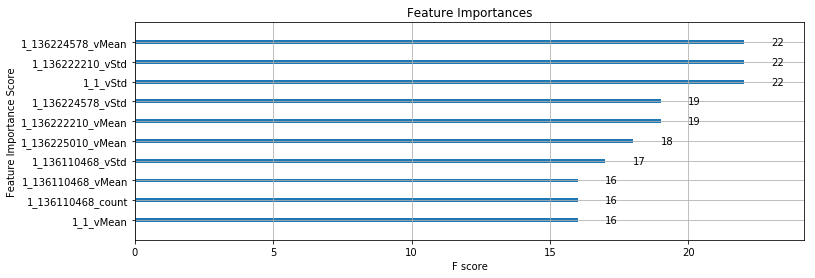

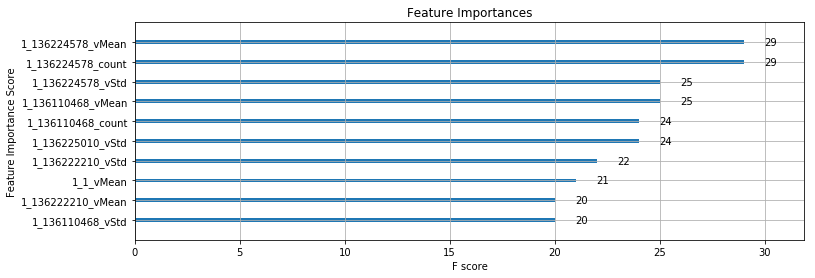

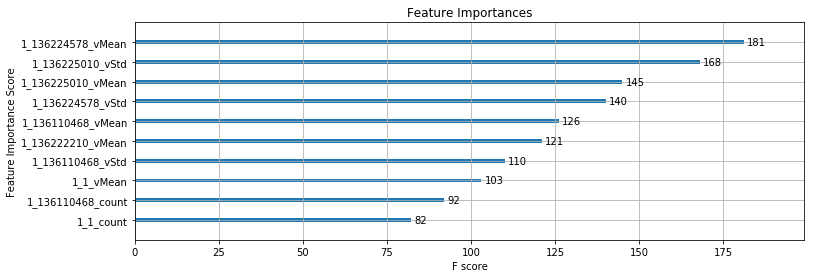

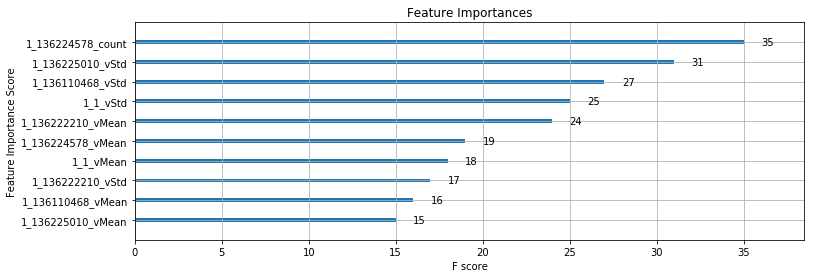

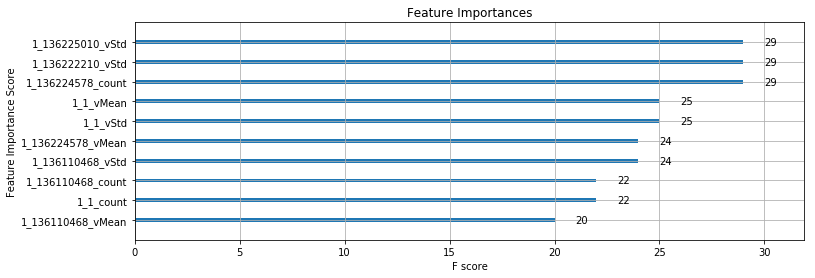

In [18]:
# do a series of experiments
choose1 = slice(1)
param1 = {'learning_rate':0.1, 'n_estimators':500, 'max_depth':5, 'min_child_weight':1,
              'gamma':0, 'subsample':0.8, 'colsample_bytree':0.8,
 'objective':'binary:logistic', 'nthread':4, 'scale_pos_weight':1, 'random_state':np.random.randint(1000), 'missing':0.0}

choose2 = slice(1)
param2 = {'learning_rate':0.1, 'n_estimators':500, 'max_depth':5, 'min_child_weight':1,
              'gamma':0, 'subsample':0.8, 'colsample_bytree':0.8,
 'objective':'binary:logistic', 'nthread':4, 'scale_pos_weight':1, 'random_state':np.random.randint(1000), 'missing':0.0}

choose3 = slice(1)
param3 = {'learning_rate':0.1, 'n_estimators':500, 'max_depth':5, 'min_child_weight':1,
              'gamma':0, 'subsample':0.8, 'colsample_bytree':0.8,
 'objective':'binary:logistic', 'nthread':4, 'scale_pos_weight':1, 'seed':np.random.randint(1000), 'missing':0.0}

choose4 = slice(1)
param4 = {'learning_rate':0.1, 'n_estimators':500, 'max_depth':5, 'min_child_weight':1,
              'gamma':0, 'subsample':0.8, 'colsample_bytree':0.8,
 'objective':'binary:logistic', 'nthread':4, 'scale_pos_weight':1, 'seed':np.random.randint(1000), 'missing':0.0}

choose5 = slice(1)
param5 = {'learning_rate':0.1, 'n_estimators':500, 'max_depth':5, 'min_child_weight':1,
              'gamma':0, 'subsample':0.8, 'colsample_bytree':0.8,
 'objective':'binary:logistic', 'nthread':4, 'scale_pos_weight':1, 'seed':np.random.randint(1000), 'missing':0.0}
test1 = all_in_one(choose1, train_data_list, test_data_list, param1, diff = 0.08, row_thres_ratio=0.75)
test2 = all_in_one(choose2, train_data_list, test_data_list, param2, diff = 0.08, row_thres_ratio=0.75)
test3 = all_in_one(choose3, train_data_list, test_data_list, param3, diff = 0.08, row_thres_ratio=0.75)
test4 = all_in_one(choose4, train_data_list, test_data_list, param4, diff = 0.08, row_thres_ratio=0.75)
test5 = all_in_one(choose5, train_data_list, test_data_list, param5, diff = 0.08, row_thres_ratio=0.75)

In [56]:
write2file('predition.csv', [test1,test2,test3,test4,test5])

[0]	train-auc:0.775321+0.0190498	test-auc:0.508+0.0658854
[10]	train-auc:0.967478+0.00555751	test-auc:0.565916+0.0554655
[20]	train-auc:0.990632+0.00161098	test-auc:0.574939+0.0512265
[30]	train-auc:0.996599+0.000585189	test-auc:0.578771+0.0441392
[40]	train-auc:0.998605+0.000333015	test-auc:0.578586+0.0365325
[50]	train-auc:0.999547+0.00014356	test-auc:0.576476+0.0355495
[60]	train-auc:0.999843+6.92604e-05	test-auc:0.571603+0.0422039
[70]	train-auc:0.999948+3.50241e-05	test-auc:0.574456+0.0463728


C:\Users\HU Wei\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9498
AUC Score (Train): 0.992004


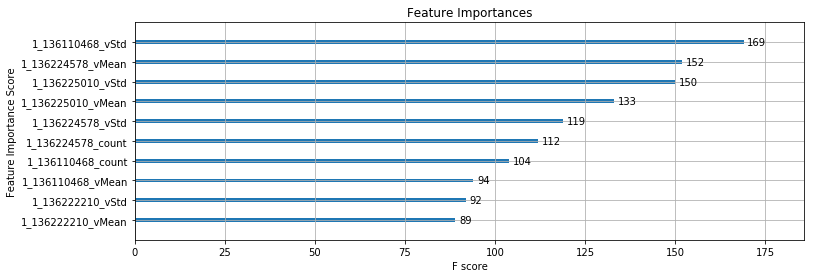

In [57]:
# cross validation group by machine id
choose = slice(1)
train_dd, test_dd = get_data(choose, train_data_list, test_data_list)
train_dd, test_dd = deleteNA_adp(train_dd, test_dd, diff = 0.08, row_thres_ratio=0.85)

train_dd = machine_id(train_dd)
predictors = test_dd.columns
gkf = list(GroupKFold(n_splits=12).split(train_dd[predictors], train_dd[target], groups=train_dd['machine_id']))
xgb_gp = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=3,
 reg_alpha=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=3,
 random_state=27)
modelfit_gp(xgb_gp, train_dd, predictors, gkf)
pred = xgb_gp.predict_proba(test_dd[predictors])
test_dd['result'] = pred[:,0]

## Get output file
write2file('predition.csv', [test_dd])

shape of data is: (8610, 37) (3283, 36)
using files: ['Training freq 1D, OW 16, PW 2.csv', 'Training freq 1D, OW 4, PW 2.csv'] ['Verification freq 1D, OW 16, PW 2_feature.csv', 'Verification freq 1D, OW 4, PW 2_feature.csv']
setting default parameters to: {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'objective': 'binary:logistic', 'nthread': 4, 'scale_pos_weight': 1, 'seed': 27, 'missing': 0.0}
Now starting training
starting tuning parameters:
{'reg_lambda': 0.001}
{'max_depth': 3, 'min_child_weight': 5}
{'gamma': 0.0}
{'colsample_bytree': 0.9, 'subsample': 0.7}
{'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 3, 'min_child_weight': 5, 'gamma': 0.0, 'subsample': 0.7, 'colsample_bytree': 0.9, 'objective': 'binary:logistic', 'nthread': 4, 'scale_pos_weight': 1, 'seed': 27, 'missing': 0.0, 'reg_lambda': 0.001}
[0]	train-auc:0.565486+0.0164274	test-auc:0.545192+0.0165613
[10]	train-auc:0.66

C:\Users\HU Wei\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9419
AUC Score (Train): 0.983213
shape of data is: (11363, 31) (3315, 30)
using files: ['Training freq 1D, OW 2, PW 2.csv', 'Training freq 1D, OW 8, PW 2.csv'] ['Verification freq 1D, OW 2, PW 2_feature.csv', 'Verification freq 1D, OW 8, PW 2_feature.csv']
setting default parameters to: {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'objective': 'binary:logistic', 'nthread': 4, 'scale_pos_weight': 1, 'seed': 27, 'missing': 0.0}
Now starting training
starting tuning parameters:
{'reg_lambda': 0.001}
{'max_depth': 3, 'min_child_weight': 3}
{'gamma': 0.3}
{'colsample_bytree': 0.6, 'subsample': 0.9}
{'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 3, 'min_child_weight': 3, 'gamma': 0.3, 'subsample': 0.9, 'colsample_bytree': 0.6, 'objective': 'binary:logistic', 'nthread': 4, 'scale_pos_weight': 1, 'seed': 27, 'missing': 0.0, 'reg_lambda': 0.001}
[0]	train-auc:0.58222

C:\Users\HU Wei\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9765
AUC Score (Train): 0.998911
shape of data is: (6623, 17) (3343, 16)
using files: ['Training freq 1D, OW 1, PW 2.csv'] ['Verification freq 1D, OW 1, PW 2_feature.csv']
setting default parameters to: {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'objective': 'binary:logistic', 'nthread': 4, 'scale_pos_weight': 1, 'seed': 27, 'missing': 0.0}
Now starting training
starting tuning parameters:
{'reg_lambda': 0.1}
{'max_depth': 3, 'min_child_weight': 1}
{'gamma': 0.2}
{'colsample_bytree': 0.7, 'subsample': 0.6}
{'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.2, 'subsample': 0.6, 'colsample_bytree': 0.7, 'objective': 'binary:logistic', 'nthread': 4, 'scale_pos_weight': 1, 'seed': 27, 'missing': 0.0, 'reg_lambda': 0.1}
[0]	train-auc:0.548453+0.0208161	test-auc:0.519593+0.0252353
[10]	train-auc:0.647184+0.00879614	test-auc:0.576

C:\Users\HU Wei\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


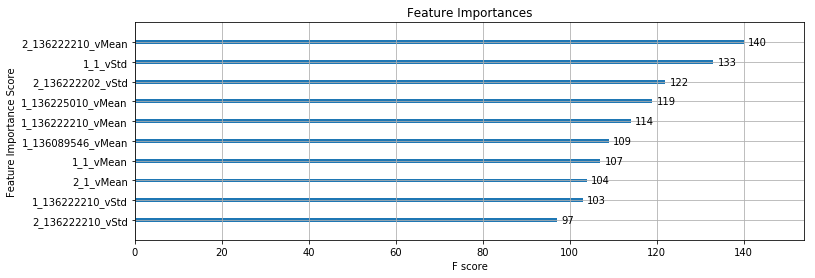

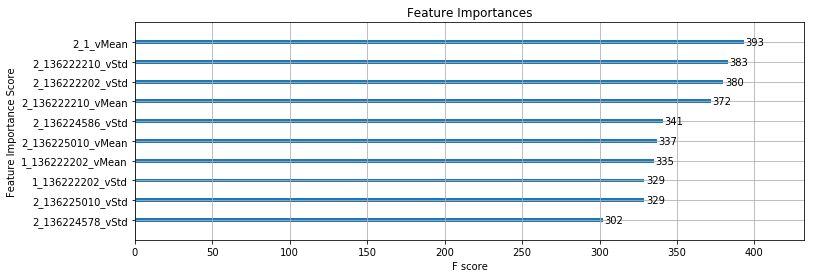

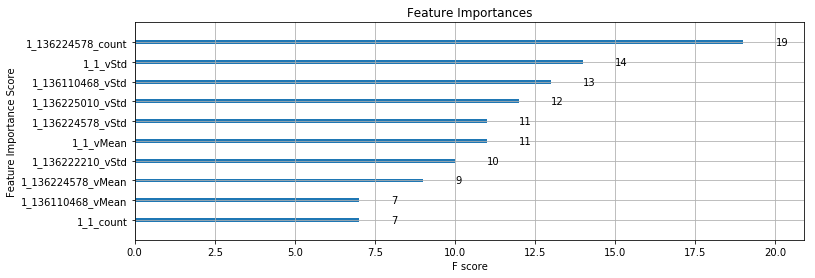

In [157]:
# another series of experiments
choose1 = slice(1,4,2)
param1 = {'learning_rate':0.1, 'n_estimators':500, 'max_depth':5, 'min_child_weight':1,
              'gamma':0, 'subsample':0.8, 'colsample_bytree':0.8,
 'objective':'binary:logistic', 'nthread':4, 'scale_pos_weight':1, 'seed':27, 'missing':0.0}
choose2 = slice(2,5,2)
param2 = {'learning_rate':0.1, 'n_estimators':500, 'max_depth':5, 'min_child_weight':1,
              'gamma':0, 'subsample':0.8, 'colsample_bytree':0.8,
 'objective':'binary:logistic', 'nthread':4, 'scale_pos_weight':1, 'seed':27, 'missing':0.0}
choose3 = slice(1)
param3 = {'learning_rate':0.1, 'n_estimators':500, 'max_depth':5, 'min_child_weight':1,
              'gamma':0, 'subsample':0.8, 'colsample_bytree':0.8,
 'objective':'binary:logistic', 'nthread':4, 'scale_pos_weight':1, 'seed':27, 'missing':0.0}
test1 = all_in_one(choose1, train_data_list, test_data_list, param1, diff = 0.12, row_thres_ratio=0.75)
test2 = all_in_one(choose2, train_data_list, test_data_list, param2, diff = 0.15, row_thres_ratio=0.7)
test3 = all_in_one(choose3, train_data_list, test_data_list, param3, diff = 0.08, row_thres_ratio=0.75)

In [168]:
write2file('predition.csv', [test1,test2,test3])